In [1]:
import os
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
print(os.listdir("C:/Users/오원석/user_name/predict"))

['items.csv', 'item_categories.csv', 'sales_train.csv', 'sample_submission.csv', 'shops.csv', 'test.csv']


In [2]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings

import workalendar
from workalendar.america import Brazil

warnings.filterwarnings('ignore')
np.random.seed(4590)

In [3]:
items=pd.read_csv("C:/Users/오원석/user_name/predict/items.csv")

In [4]:
categories=pd.read_csv("C:/Users/오원석/user_name/predict/item_categories.csv")

In [5]:
train=pd.read_csv("C:/Users/오원석/user_name/predict/sales_train.csv")

In [6]:
shops=pd.read_csv("C:/Users/오원석/user_name/predict/shops.csv")

In [7]:
test=pd.read_csv("C:/Users/오원석/user_name/predict/test.csv")

In [8]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
train.shape

(2935849, 6)

In [10]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [11]:
test.shape

(214200, 3)

In [12]:
train['item_id'].value_counts(ascending=False)[:5]

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
Name: item_id, dtype: int64

In [13]:
items.loc[items['item_id']==20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


In [14]:
categories.loc[categories['item_category_id']==71]

,item_category_name,item_category_id
71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71


In [15]:
test.loc[test['item_id']==20949].head(5)

,ID,shop_id,item_id
460,460,5,20949
5560,5560,4,20949
10660,10660,6,20949
15760,15760,3,20949
20860,20860,2,20949


In [16]:
train['item_cnt_day'].sort_values(ascending=False)[:5]

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
Name: item_cnt_day, dtype: float64

In [17]:
train[train['item_cnt_day'] == 2169]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [18]:
items[items['item_id'] == 11373]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


In [19]:
train[train['item_id'] == 11373].head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
58323,08.01.2013,0,12,11373,1000.0,1.0
58324,31.01.2013,0,12,11373,97.8,5.0
176790,01.02.2013,1,12,11373,229.0,1.0
176791,04.02.2013,1,12,11373,130.0,1.0
302468,29.03.2013,2,12,11373,139.5,2.0


In [20]:
train = train[train['item_cnt_day'] < 2000]

In [21]:
train['item_price'].sort_values(ascending=False)[:5]

1163158    307980.0
885138      59200.0
1488135     50999.0
2327159     49782.0
2917760     42990.0
Name: item_price, dtype: float64

In [22]:
train[train['item_price'] == 307980]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [23]:
items[items['item_id'] == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [24]:
train[train['item_id'] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [25]:
train = train[train['item_price'] < 300000]

In [26]:
train['item_price'].sort_values()[:5]

484683   -1.0000
608763    0.0700
579766    0.0700
611400    0.0875
673155    0.0900
Name: item_price, dtype: float64

In [27]:
train[train['item_price'] == -1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [28]:
train[train['item_id'] == 2973].head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352,15.01.2013,0,25,2973,2499.0,13.0
353,16.01.2013,0,25,2973,2499.0,5.0
354,17.01.2013,0,25,2973,2499.0,3.0
355,18.01.2013,0,25,2973,2499.0,2.0
356,19.01.2013,0,25,2973,2499.0,3.0


In [29]:
price_correction = train[(train['shop_id'] == 32) & (train['item_id'] == 2973) & (train['date_block_num'] == 4) & (train['item_price'] > 0)].item_price.median()
train.loc[train['item_price'] < 0, 'item_price'] = price_correction

In [30]:
train['item_price'].sort_values()[:5]

579766    0.0700
608763    0.0700
611400    0.0875
673155    0.0900
548080    0.1000
Name: item_price, dtype: float64

In [31]:
shops_train = train['shop_id'].nunique()
shops_test = test['shop_id'].nunique()
print('Shops in Training Set: ', shops_train)
print('Shops in Test Set: ', shops_test)

Shops in Training Set:  60
Shops in Test Set:  42


In [32]:
shops_train_list = list(train['shop_id'].unique())
shops_test_list = list(test['shop_id'].unique())

flag = 0
if(set(shops_test_list).issubset(set(shops_train_list))): 
    flag = 1
      
if (flag) : 
    print ("Yes, list is subset of other.") 
else : 
    print ("No, list is not subset of other.") 

Yes, list is subset of other.


In [33]:
shops.T

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
shop_name,"!Якутск Орджоникидзе, 56 фран","!Якутск ТЦ ""Центральный"" фран","Адыгея ТЦ ""Мега""","Балашиха ТРК ""Октябрь-Киномир""","Волжский ТЦ ""Волга Молл""","Вологда ТРЦ ""Мармелад""","Воронеж (Плехановская, 13)","Воронеж ТРЦ ""Максимир""","Воронеж ТРЦ Сити-Парк ""Град""",Выездная Торговля,...,"Тюмень ТЦ ""Гудвин""","Тюмень ТЦ ""Зеленый Берег""","Уфа ТК ""Центральный""","Уфа ТЦ ""Семья"" 2","Химки ТЦ ""Мега""",Цифровой склад 1С-Онлайн,"Чехов ТРЦ ""Карнавал""","Якутск Орджоникидзе, 56","Якутск ТЦ ""Центральный""","Ярославль ТЦ ""Альтаир"""
shop_id,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59


In [34]:
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

In [35]:
cities = shops['shop_name'].str.split(' ').map(lambda row: row[0])
cities.unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [36]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda row: row[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [37]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit_transform(shops['city'])

array([29, 29,  0,  1,  2,  3,  4,  4,  4,  5,  6,  6,  7,  8,  8,  9, 10,
       11, 11, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14,
       15, 15, 16, 16, 17, 18, 18, 18, 19, 19, 20, 20, 21, 22, 23, 24, 24,
       24, 25, 25, 26, 27, 28, 29, 29, 30])

In [38]:
shops['city_label'] = le.fit_transform(shops['city'])
shops.drop(['shop_name', 'city'], axis = 1, inplace = True)
shops.head()

,shop_id,city_label
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [39]:
items_train = train['item_id'].nunique()
items_test = test['item_id'].nunique()
print('Items in Training Set: ', items_train)
print('Items in Test Set: ', items_test)

Items in Training Set:  21806
Items in Test Set:  5100


In [40]:
items_train_list = list(train['item_id'].unique())
items_test_list = list(test['item_id'].unique())

flag = 0
if(set(items_test_list).issubset(set(items_train_list))): 
    flag = 1
      
if (flag) : 
    print ("Yes, list is subset of other.") 
else : 
    print ("No, list is not subset of other.") 

No, list is not subset of other.


In [41]:
len(set(items_test_list).difference(items_train_list))

363

In [42]:
categories_in_test = items.loc[items['item_id'].isin(sorted(test['item_id'].unique()))].item_category_id.unique()

In [43]:
categories.loc[~categories['item_category_id'].isin(categories_in_test)].T

,1,4,8,10,13,14,17,18,32,39,...,50,51,52,53,59,66,68,80,81,82
item_category_name,Аксессуары - PS2,Аксессуары - PSP,Билеты (Цифра),Игровые консоли - PS2,Игровые консоли - PSP,Игровые консоли - PSVita,Игровые консоли - Прочие,Игры - PS2,"Карты оплаты (Кино, Музыка, Игры)",Кино - Blu-Ray 4K,...,Книги - Открытки,Книги - Познавательная литература,Книги - Путеводители,Книги - Художественная литература,Музыка - Музыкальное видео,"Подарки - Открытки, наклейки","Подарки - Сертификаты, услуги",Служебные - Билеты,Чистые носители (шпиль),Чистые носители (штучные)
item_category_id,1,4,8,10,13,14,17,18,32,39,...,50,51,52,53,59,66,68,80,81,82


In [44]:
le = preprocessing.LabelEncoder()

main_categories = categories['item_category_name'].str.split('-')
categories['main_category_id'] = main_categories.map(lambda row: row[0].strip())
categories['main_category_id'] = le.fit_transform(categories['main_category_id'])

# Some items don't have sub-categories. For those, we will use the main category as a sub-category
categories['sub_category_id'] = main_categories.map(lambda row: row[1].strip() if len(row) > 1 else row[0].strip())
categories['sub_category_id'] = le.fit_transform(categories['sub_category_id'])

In [45]:
categories.head()

,item_category_name,item_category_id,main_category_id,sub_category_id
0,PC - Гарнитуры/Наушники,0,0,29
1,Аксессуары - PS2,1,1,9
2,Аксессуары - PS3,2,1,10
3,Аксессуары - PS4,3,1,11
4,Аксессуары - PSP,4,1,13


In [46]:
train['date'] =  pd.to_datetime(train['date'], format='%d.%m.%Y')

In [47]:
from itertools import product

In [48]:
s = [['a','b','c'],['1','2','3','4'],['!','@','#']]
list(product(*s))

[('a', '1', '!'),
 ('a', '1', '@'),
 ('a', '1', '#'),
 ('a', '2', '!'),
 ('a', '2', '@'),
 ('a', '2', '#'),
 ('a', '3', '!'),
 ('a', '3', '@'),
 ('a', '3', '#'),
 ('a', '4', '!'),
 ('a', '4', '@'),
 ('a', '4', '#'),
 ('b', '1', '!'),
 ('b', '1', '@'),
 ('b', '1', '#'),
 ('b', '2', '!'),
 ('b', '2', '@'),
 ('b', '2', '#'),
 ('b', '3', '!'),
 ('b', '3', '@'),
 ('b', '3', '#'),
 ('b', '4', '!'),
 ('b', '4', '@'),
 ('b', '4', '#'),
 ('c', '1', '!'),
 ('c', '1', '@'),
 ('c', '1', '#'),
 ('c', '2', '!'),
 ('c', '2', '@'),
 ('c', '2', '#'),
 ('c', '3', '!'),
 ('c', '3', '@'),
 ('c', '3', '#'),
 ('c', '4', '!'),
 ('c', '4', '@'),
 ('c', '4', '#')]

In [49]:
###전체 월에 대해 만들기 전에 1월 2월만 해놓자
shops_in_jan = train.loc[train['date_block_num']==0, 'shop_id'].unique()
items_in_jan = train.loc[train['date_block_num']==0, 'item_id'].unique()
jan = list(product(*[shops_in_jan, items_in_jan, [0]]))

In [50]:
print(len(jan))

365175


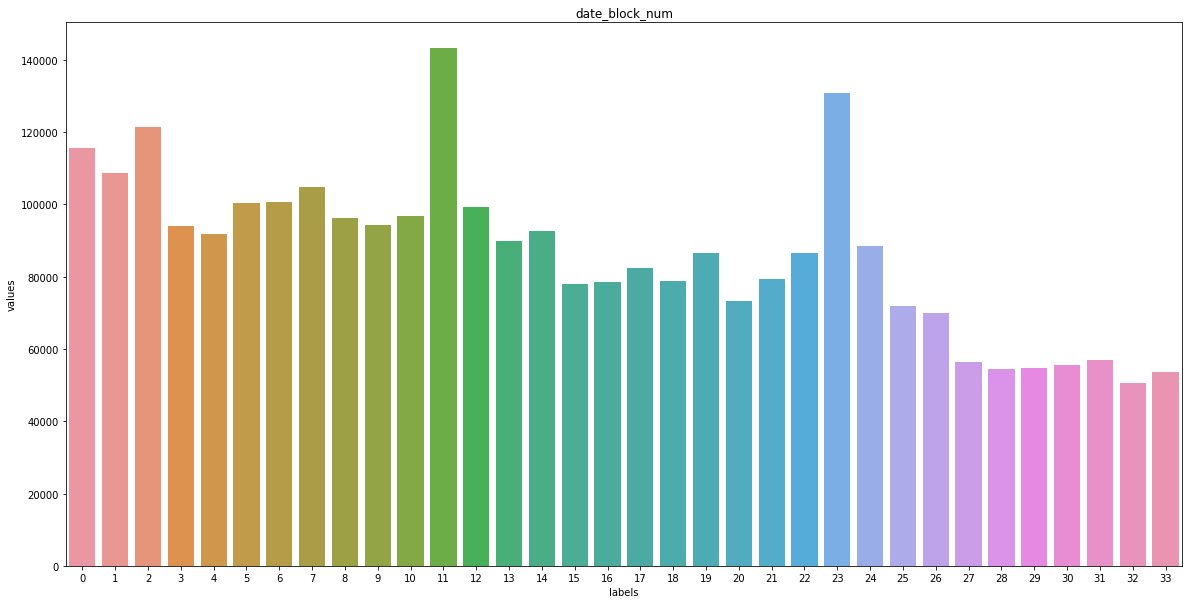

In [51]:
temp = train["date_block_num"].value_counts()
df = pd.DataFrame({'labels':temp.index,
                'values':temp.values})
plt.figure(figsize=(20,10))
plt.title('date_block_num')
sns.barplot(x='labels', y='values', data=df)
plt.show()

In [52]:
train.loc[train['date_block_num']==0].describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,115690.0,115690.000000,115690.000000,115690.000000,115690.000000
mean,0.0,33.232795,10234.002827,710.622127,1.136477
std,0.0,16.021740,6299.371351,1244.194664,0.679514
min,0.0,2.000000,19.000000,9.000000,-6.000000
25%,0.0,23.000000,4464.000000,199.000000,1.000000
50%,0.0,31.000000,9743.000000,399.000000,1.000000
75%,0.0,47.000000,15555.000000,719.440000,1.000000
max,0.0,59.000000,22168.000000,32990.000000,64.000000


In [53]:
shops_in_feb = train.loc[train['date_block_num']==1, 'shop_id'].unique()
items_in_feb = train.loc[train['date_block_num']==1, 'item_id'].unique()
feb = list(product(*[shops_in_feb, items_in_feb, [1]]))

In [54]:
print(len(feb))

375728


In [55]:
train.loc[train['date_block_num']==1].describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,108613.0,108613.000000,108613.000000,108613.000000,108613.000000
mean,1.0,32.880318,9907.138004,695.866856,1.179325
std,0.0,16.120234,6340.161728,1128.665910,0.883316
min,1.0,2.000000,12.000000,9.000000,-4.000000
25%,1.0,22.000000,4161.000000,206.000000,1.000000
50%,1.0,31.000000,9041.000000,399.000000,1.000000
75%,1.0,47.000000,15134.000000,799.000000,1.000000
max,1.0,59.000000,22168.000000,25500.000000,53.000000


In [56]:
cartesian_test = []
cartesian_test.append(np.array(jan))
cartesian_test.append(np.array(feb))

In [57]:
cartesian_test

[array([[   59, 22154,     0],
        [   59,  2552,     0],
        [   59,  2554,     0],
        ...,
        [   45,   628,     0],
        [   45,   631,     0],
        [   45,   621,     0]], dtype=int64),
 array([[   50,  3880,     1],
        [   50,  4128,     1],
        [   50,  4124,     1],
        ...,
        [   28, 12885,     1],
        [   28, 12791,     1],
        [   28, 13433,     1]], dtype=int64)]

In [58]:
cartesian_test = np.vstack(cartesian_test)

In [59]:
###vstack 배열연결
### 열의 수가 같은 두개 이상의 배열을 위아래로 연결하여 행의 수가 더 많은 배열을 만듬

In [60]:
cartesian_test_df = pd.DataFrame(cartesian_test, columns = ['shop_id', 'item_id', 'date_block_num'])

In [61]:
cartesian_test_df.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [62]:
cartesian_test_df.shape

(740903, 3)

In [63]:
from tqdm import tqdm_notebook

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

In [64]:
months = train['date_block_num'].unique()

In [65]:
cartesian = []
for month in months:
    shops_in_month = train.loc[train['date_block_num']==month, 'shop_id'].unique()
    items_in_month = train.loc[train['date_block_num']==month, 'item_id'].unique()
    cartesian.append(np.array(list(product(*[shops_in_month, items_in_month, [month]])), dtype='int32'))


In [66]:
cartesian_df = pd.DataFrame(np.vstack(cartesian), columns = ['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)

In [67]:
cartesian_df.shape

(10913804, 3)

In [68]:
###월 단위로 매출 집계 및 목표 변수 클리핑

In [69]:
x = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
x.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,27,0,1.0
1,2,27,17,1.0
2,2,30,2,1.0
3,2,30,5,1.0
4,2,30,15,1.0


In [70]:
x.shape

(1609123, 4)

In [71]:
new_train = pd.merge(cartesian_df, x, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)

In [72]:
new_train['item_cnt_month'] = np.clip(new_train['item_cnt_month'], 0, 20)

In [73]:
del x
del cartesian_df
del cartesian
del cartesian_test
del cartesian_test_df
del feb
del jan
del items_test_list
del items_train_list
del train

In [77]:
new_train.sort_values(['date_block_num','shop_id','item_id'], inplace = True)
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month
114910,2,19,0,0.0
117150,2,27,0,1.0
120623,2,28,0,0.0
118316,2,29,0,0.0
114602,2,32,0,0.0


In [78]:
test.insert(loc=3, column='date_block_num', value=34)

ValueError: cannot insert date_block_num, already exists

In [76]:
test['item_cnt_month'] = 0

In [79]:
test.head()

,ID,shop_id,item_id,date_block_num,item_cnt_month
0,0,5,5037,34,0
1,1,5,5320,34,0
2,2,5,5233,34,0
3,3,5,5232,34,0
4,4,5,5268,34,0


In [80]:
new_train = new_train.append(test.drop('ID',axis = 1))

In [81]:
new_train = pd.merge(new_train, shops, on=['shop_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label
0,2,19,0,0.0,0
1,2,27,0,1.0,0
2,2,28,0,0.0,0
3,2,29,0,0.0,0
4,2,32,0,0.0,0


In [82]:
new_train = pd.merge(new_train, items.drop('item_name', axis = 1), on=['item_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id
0,2,19,0,0.0,0,40
1,2,27,0,1.0,0,19
2,2,28,0,0.0,0,30
3,2,29,0,0.0,0,23
4,2,32,0,0.0,0,40


In [83]:
new_train = pd.merge(new_train, categories.drop('item_category_name', axis = 1), on=['item_category_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id
0,2,19,0,0.0,0,40,11,4
1,2,27,0,1.0,0,19,5,10
2,2,28,0,0.0,0,30,8,55
3,2,29,0,0.0,0,23,5,16
4,2,32,0,0.0,0,40,11,4


In [84]:
def generate_lag(train, months, lag_column):
    for month in months:
        # Speed up by grabbing only the useful bits
        train_shift = train[['date_block_num', 'shop_id', 'item_id', lag_column]].copy()
        train_shift.columns = ['date_block_num', 'shop_id', 'item_id', lag_column+'_lag_'+ str(month)]
        train_shift['date_block_num'] += month
        train = pd.merge(train, train_shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return train


In [84]:
del items
del categories
del shops
del test

In [85]:
new_train = downcast_dtypes(new_train)

In [86]:
import gc
gc.collect()

2318

In [87]:
%%time
new_train = generate_lag(new_train, [1,2,3,4,5,6,12], 'item_cnt_month')

Wall time: 55.1 s


In [91]:
new_train.tail()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_12,item_month_mean_lag_1,item_month_mean_lag_2,item_month_mean_lag_3,item_month_mean_lag_6,item_month_mean_lag_12,shop_month_mean_x,shop_month_mean_y
11127999,45,18454,34,0.0,20,55,13,2,1.0,0.0,...,0.0,0.0,NaN,0.045441,0.023254,0.071411,0.590820,NaN,0.0,0.0
11128000,45,16188,34,0.0,20,64,14,42,0.0,0.0,...,NaN,NaN,NaN,0.022720,0.069763,NaN,NaN,NaN,0.0,0.0
11128001,45,15757,34,0.0,20,55,13,2,0.0,0.0,...,0.0,0.0,0.0,0.113647,0.069763,0.095215,0.250000,0.180054,0.0,0.0
11128002,45,19648,34,0.0,20,40,11,4,0.0,0.0,...,0.0,0.0,NaN,0.045441,0.069763,0.166626,0.090881,NaN,0.0,0.0
11128003,45,969,34,0.0,20,37,11,1,0.0,0.0,...,0.0,0.0,0.0,0.068176,0.116272,0.023804,0.068176,0.119995,0.0,0.0


In [92]:
new_train['month'] = new_train['date_block_num'] % 12

In [93]:
holiday_dict = {
    0: 6,
    1: 3,
    2: 2,
    3: 8,
    4: 3,
    5: 3,
    6: 2,
    7: 8,
    8: 4,
    9: 8,
    10: 5,
    11: 4,
}

In [94]:
new_train['holidays_in_month'] = new_train['month'].map(holiday_dict)

In [95]:
moex = {
    12: 659, 13: 640, 14: 1231,
    15: 881, 16: 764, 17: 663,
    18: 743, 19: 627, 20: 692,
    21: 736, 22: 680, 23: 1092,
    24: 657, 25: 863, 26: 720,
    27: 819, 28: 574, 29: 568,
    30: 633, 31: 658, 32: 611,
    33: 770, 34: 723,
}

In [96]:
new_train['moex_value'] = new_train.date_block_num.map(moex)

In [97]:
new_train = downcast_dtypes(new_train)

In [85]:
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id
0,2,19,0,0.0,0,40,11,4
1,2,27,0,1.0,0,19,5,10
2,2,28,0,0.0,0,30,8,55
3,2,29,0,0.0,0,23,5,16
4,2,32,0,0.0,0,40,11,4


In [94]:
gp_category_mean = new_train.groupby(['item_category_id'], as_index=False)['item_cnt_month'].mean()
gp_category_sum = new_train.groupby(['item_category_id'], as_index=False)['item_cnt_month'].sum()
gp_shop_mean = new_train.groupby(['shop_id'], as_index=False)['item_cnt_month'].mean()
gp_shop_sum = new_train.groupby(['shop_id'], as_index=False)['item_cnt_month'].sum()

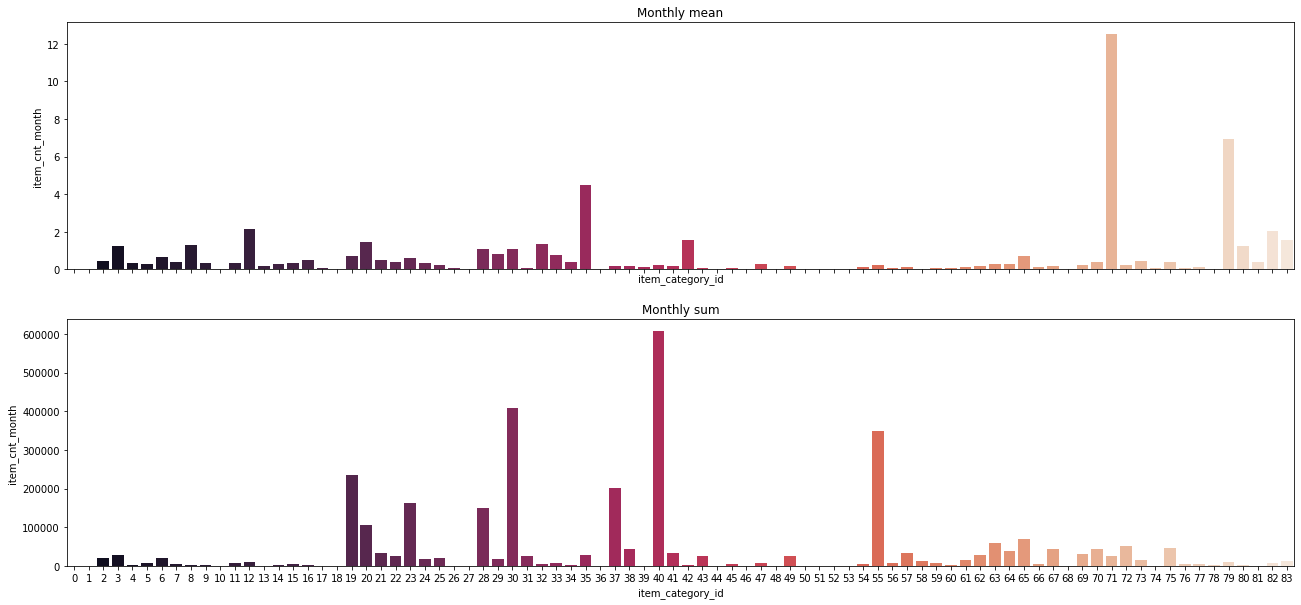

In [96]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt_month", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt_month", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

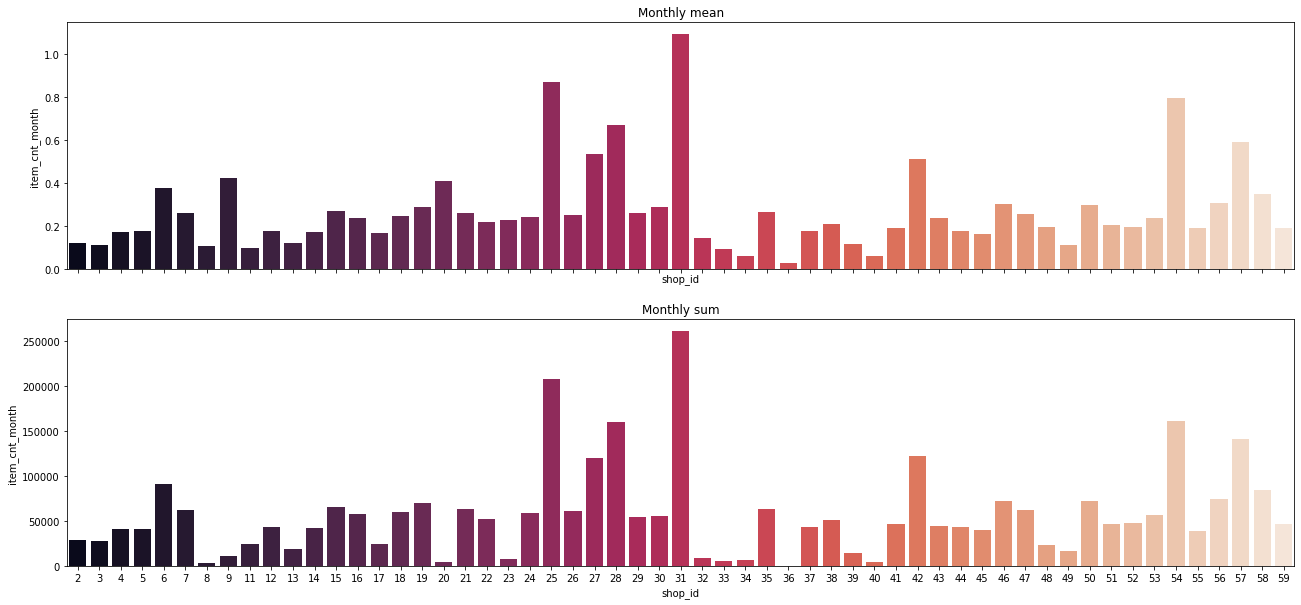

In [97]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt_month", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt_month", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()